In [9]:
import importlib
import os
from dotenv import load_dotenv
import polars as pl

from art.utils.benchmarking.load_trajectories import load_trajectories
from art.utils.benchmarking.charts import percentage_comparison_bar_chart, training_progress_chart
import art.utils.benchmarking.charts
from art.utils.benchmarking.types import BenchmarkModelKey
from art.utils.get_repo_root_path import get_repo_root_path
from art.utils.s3 import pull_model_from_s3


importlib.reload(art.utils.benchmarking.charts)

load_dotenv()

project_name = "2048"

PULL_MODELS = False
if PULL_MODELS:
    await pull_model_from_s3(
        model_name="003",
        project=project_name,
    )
    await pull_model_from_s3(
        model_name="gpt-4o",
        project=project_name,
    )
    await pull_model_from_s3(
        model_name="gpt-4.1",
        project=project_name,
    )
    await pull_model_from_s3(
        model_name="gpt-4o-mini",
        project=project_name,
    )

# await load_trajectories.bust_cache()
df = await load_trajectories(
    project_name=project_name,
    models=["003", "gpt-4o", "gpt-4.1", "gpt-4o-mini"],
)

benchmarks_dir = f"{get_repo_root_path()}/assets/benchmarks/{project_name}"

os.makedirs(benchmarks_dir, exist_ok=True)

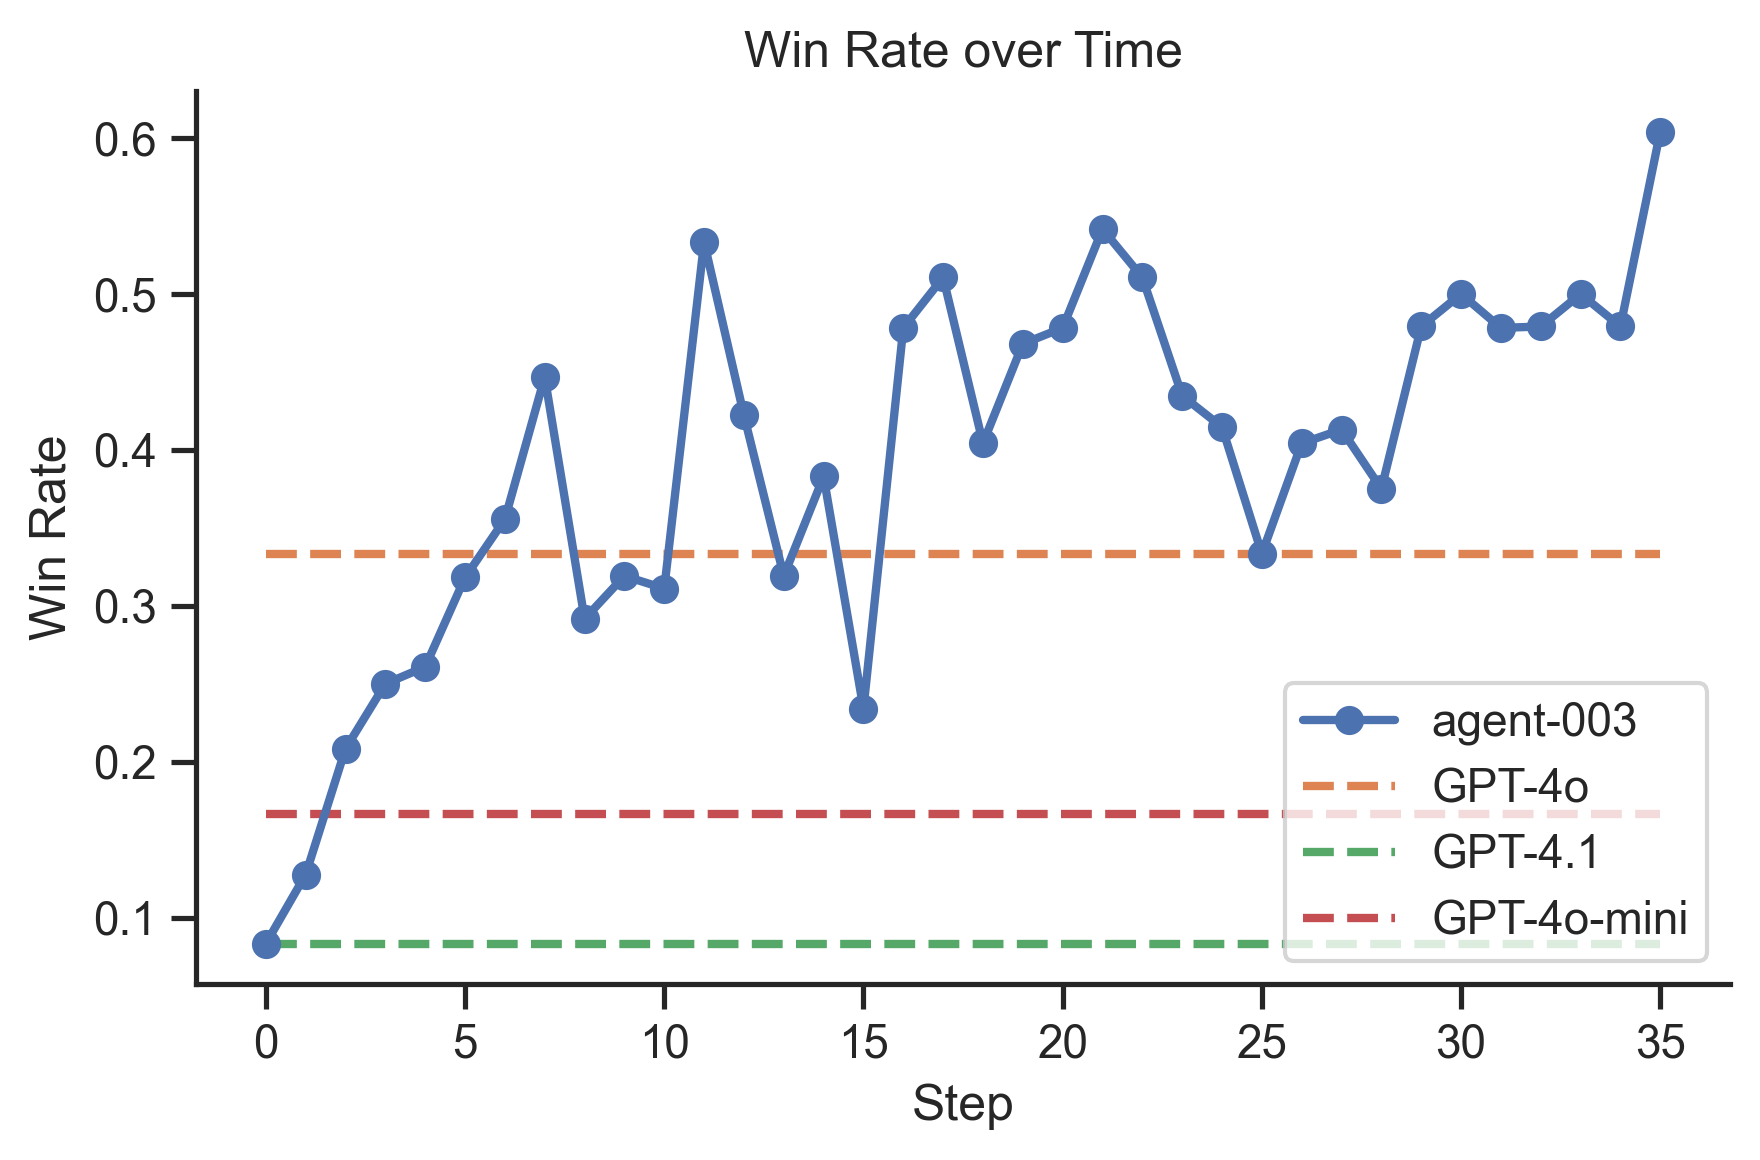

In [10]:
line_graph = training_progress_chart(
    df,
    "win",
    models=[
        BenchmarkModelKey("003", "agent-003", "train"),
        BenchmarkModelKey("gpt-4o", "GPT-4o"),
        BenchmarkModelKey("gpt-4.1", "GPT-4.1"),
        BenchmarkModelKey("gpt-4o-mini", "GPT-4o-mini"),
    ],
    title="Win Rate over Time",
    y_label="Win Rate",
)
line_graph.savefig(
    f"{benchmarks_dir}/accuracy-training-progress.svg"
)

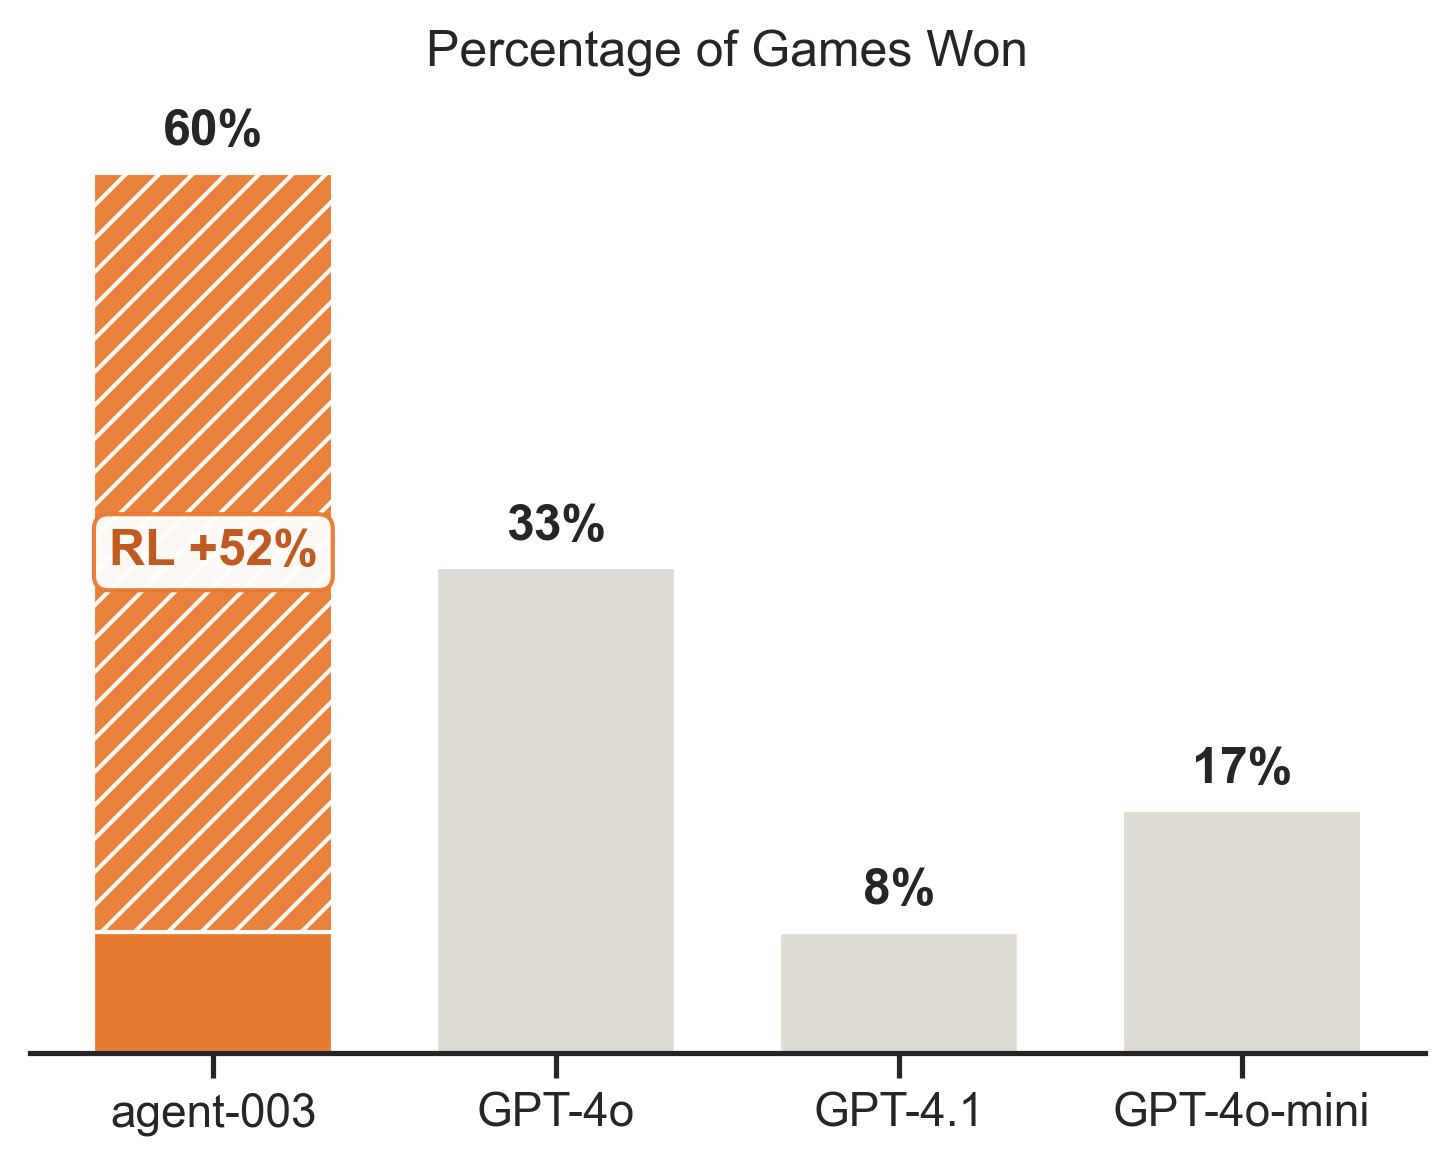

In [11]:
bar_chart = percentage_comparison_bar_chart(
    df,
    metric_name="win",
    models=[
        BenchmarkModelKey("003", "agent-003", "train"),
        BenchmarkModelKey("gpt-4o", "GPT-4o"),
        BenchmarkModelKey("gpt-4.1", "GPT-4.1"),
        BenchmarkModelKey("gpt-4o-mini", "GPT-4o-mini"),
    ],
    title="Percentage of Games Won",
)
bar_chart.savefig(
    f"{benchmarks_dir}/accuracy-comparison.svg"
)